In [15]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install pycountry

torch.manual_seed(7)
torch.cuda.manual_seed(7)
torch.cuda.manual_seed_all(7)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data Ingestion

In [16]:
import pandas as pd

ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding='latin-1')
users = pd.read_csv('BX-Users.csv', sep=';', encoding='latin-1')
books = pd.read_csv('BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip', engine="python")

# EDA Ratings

In [17]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Total number of users:

In [18]:
len(ratings["User-ID"].unique())

105283

ISBN is the ID for every book, total number of books:

In [19]:
len(ratings["ISBN"].unique())

340556

In [20]:
isbn_counts = ratings.groupby('ISBN').size()

count_occurrences = isbn_counts.value_counts().to_frame()
count_occurrences.reset_index(inplace=True)
count_occurrences.columns = ["Number of Books", "Number of Ratings"]
count_occurrences.head()

,Number of Books,Number of Ratings
0,1,197045
1,2,59664
2,3,25976
3,4,14106
4,5,9008


In [21]:
count_occurrences.tail()

,Number of Books,Number of Ratings
327,233,1
328,552,1
329,380,1
330,213,1
331,217,1


In [22]:
import plotly.express as px
plot_sample = 20
fig = px.bar(
    count_occurrences.head(plot_sample),
    x = "Number of Books",
    y = "Number of Ratings",
    title=f"Number of times Boooks Were Rated (top {plot_sample})",

)
fig.show()

Exploring book's ratings:

In [23]:
possible_ratings = sorted(ratings["Book-Rating"].unique().tolist())
possible_ratings

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Frequency for every rating value:

In [24]:
frequency_ratings_df = ratings["Book-Rating"].value_counts()[possible_ratings]
frequency_ratings_df

0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: Book-Rating, dtype: int64

In [25]:

fig = px.bar(
    frequency_ratings_df,
    title="Book Rating Distribution",
    labels={
        "value":"Frequency",
        "index":"Book Rating"
    }
)
fig.show()

# EDA user data:

In [26]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Total number of users:

In [27]:
len(users["User-ID"].unique())

278858

User´s age:

In [28]:
fig = px.histogram(
    users,
    x="Age",
    title="User's Age Distribution",
    labels={
        #"count":"Frequency",
        "Age": "User's Age"
    }
)
fig.show()

Some user's are older than 100 years old, that is unlikely and be candidates to be removed.



In [29]:
from tqdm import tqdm

city_location_dict = {}
state_location_dict = {}
country_location_dict = {}


for row in tqdm(users["Location"]):
  # separate city, state and country data
  row_data = row.split(",")

  if len(row_data) < 3:
    print("")
    print("_"*20)
    print("Ignored row including less than 3 items:")
    print(row_data)
    print("_"*20)
    continue

  row_city = row_data[0].upper()
  row_state = row_data[1].upper()
  row_country = row_data[-1].upper()

  # store info in dictionaries
  # try:
  #   city_location_dict[row_city] = city_location_dict.get(row_city, 0) + 1
  # except:
  #   print(row_city)
  # try:
  #   state_location_dict[row_state] = state_location_dict.get(row_state) + 1
  # except:
  #   print(row_state)
  # try:
  #   country_location_dict[row_country] = country_location_dict.get(row_country) + 1
  # except:
  #   print(row_country)

  try:
    country_location_dict[row_country] = country_location_dict.get(row_country, 0) + 1
  except:
    print(row_country)



 31%|███       | 86921/278858 [00:00<00:00, 441646.48it/s]


____________________
Ignored row including less than 3 items:
['st. louis', ' missouri']
____________________


100%|██████████| 278858/278858 [00:00<00:00, 588104.23it/s]


____________________
Ignored row including less than 3 items:
['lawrenceville']
____________________


In [30]:
country_books_df = pd.DataFrame.from_dict(
    country_location_dict,
    orient="index",
    columns=["Frequency"]
)
country_books_df.head()

,Frequency
USA,139711
RUSSIA,178
PORTUGAL,3325
UNITED KINGDOM,18538
CANADA,21658


Most users come from the United States, other countrys fall far behind in frequency.

In [31]:
country_books_df.sort_values("Frequency", ascending=False).head(10)

,Frequency
USA,139711
CANADA,21658
UNITED KINGDOM,18538
GERMANY,17043
SPAIN,13147
AUSTRALIA,11784
ITALY,11266
,4578
FRANCE,3455
PORTUGAL,3325


Checking for the median frequency value, countries that only appear once are removed from the analysis:

In [32]:
country_mask = country_books_df["Frequency"] > 1
country_books_df = country_books_df[country_mask]

country_books_df["Frequency"].median()

11.0

In [33]:
country_books_df.sort_values("Frequency", ascending=True).head(10)

,Frequency
SAINT KITTS AND NEVIS,2
"CHINA""",2
UNIVERSE,2
SOLOMON ISLANDS,2
MALAWI,2
"LUXEMBOURG""",2
SRILANKA,2
NRW,2
LA BELGIQUE,2
HOLLAND,2


In [34]:
country_upper_mask = country_books_df["Frequency"] <=  5000

fig = px.histogram(
    country_books_df[country_upper_mask]
    ,
    x="Frequency",
    title="User's Country Distribution (not including USA)",
    labels={
        #"count":"Frequency",
        "Frequency": "User's Country"
    }
)
fig.show()

In [35]:
country_books_df.reset_index(inplace=True)
country_books_df.columns = ["Country", "Users"]
country_books_df["Country"] = country_books_df.Country.str.title()
country_books_df["Country"] = country_books_df.Country.str.strip()

country_books_df.head()

<ipython-input-35-4710a71830c4>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-35-4710a71830c4>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Country,Users
0,Usa,139711
1,Russia,178
2,Portugal,3325
3,United Kingdom,18538
4,Canada,21658


In [36]:
num_countries = 21
top_countries = country_books_df.sort_values(by="Users", ascending=False).head(num_countries)
top_countries.replace({"Usa":"United States"}, inplace=True)
top_countries.drop(8, inplace=True)
top_countries

,Country,Users
0,United States,139711
4,Canada,21658
3,United Kingdom,18538
9,Germany,17043
5,Spain,13147
6,Australia,11784
12,Italy,11266
13,France,3455
2,Portugal,3325
17,New Zealand,3097


In [37]:
import pycountry

input_countries = top_countries["Country"].tolist()

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

codes = [countries.get(country, 'Unknown code') for country in input_countries]

print(codes)  # prints ['AS', 'CA', 'FR']
print(input_countries)

['USA', 'CAN', 'GBR', 'DEU', 'ESP', 'AUS', 'ITA', 'FRA', 'PRT', 'NZL', 'NLD', 'CHE', 'BRA', 'CHN', 'SWE', 'IND', 'AUT', 'MYS', 'ARG', 'SGP']
['United States', 'Canada', 'United Kingdom', 'Germany', 'Spain', 'Australia', 'Italy', 'France', 'Portugal', 'New Zealand', 'Netherlands', 'Switzerland', 'Brazil', 'China', 'Sweden', 'India', 'Austria', 'Malaysia', 'Argentina', 'Singapore']


In [38]:
top_countries["iso_alpha"] = codes

In [39]:
top_countries

,Country,Users,iso_alpha
0,United States,139711,USA
4,Canada,21658,CAN
3,United Kingdom,18538,GBR
9,Germany,17043,DEU
5,Spain,13147,ESP
6,Australia,11784,AUS
12,Italy,11266,ITA
13,France,3455,FRA
2,Portugal,3325,PRT
17,New Zealand,3097,NZL


In [40]:
fig = px.choropleth(
    top_countries,
    locations="iso_alpha",
    color="Users", # lifeExp is a column of gapminder
    hover_name="Country", # column to add to hover information
    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

# EDA Books

Column names in the dataset:

In [41]:
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

Book IDs

In [42]:
len(books["ISBN"].unique())

117856

Unique Book Titles

In [43]:
len(books["Book-Title"].unique())

106833

Unique Book Authors

In [44]:
len(books["Book-Author"].unique())

48828

Distribution Year of publication:

In [45]:
fig = px.histogram(
    books,
    x="Year-Of-Publication",
    title="Year of Publication Distribution",
    labels={
        #"count":"Frequency",
        'Year-Of-Publication': 'Year Of Publication'
    }
)
fig.show()

Unique publishers:

In [46]:
len(books["Publisher"].unique())

9022

Last 3 columns show the URL of Book Images:

In [47]:
books[['Image-URL-S', 'Image-URL-M', 'Image-URL-L']].head(3)

,Image-URL-S,Image-URL-M,Image-URL-L
0,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


# Data Processing

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [56]:
df = ratings
# Preprocessing
df = df.loc[df['ISBN'].isin(books['ISBN'].unique()) & df['User-ID'].isin(users['User-ID'].unique())]

# Keep the 100k highest ratings
df = df[df['Book-Rating'] >= 8].iloc[:100000]

In [57]:
# Create mappings
user_mapping = {userid: i for i, userid in enumerate(df['User-ID'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(df['ISBN'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items

In [58]:
# Build the adjacency matrix based on user ratings
user_ids = torch.LongTensor([user_mapping[i] for i in df['User-ID']])
item_ids = torch.LongTensor([item_mapping[i] for i in df['ISBN']])
edge_index = torch.stack((user_ids, item_ids))

In [59]:
# Create training, validation, and test adjacency matrices
train_index, test_index = train_test_split(range(len(df)), test_size=0.2, random_state=0)
val_index, test_index = train_test_split(test_index, test_size=0.5, random_state=0)

train_edge_index = edge_index[:, train_index]
val_edge_index = edge_index[:, val_index]
test_edge_index = edge_index[:, test_index]

In [60]:
def sample_mini_batch(edge_index):
    # Generate BATCH_SIZE random indices
    index = np.random.choice(range(edge_index.shape[1]), size=BATCH_SIZE)

    # Generate negative sample indices
    edge_index = structured_negative_sampling(edge_index)
    edge_index = torch.stack(edge_index, dim=0)

    user_index = edge_index[0, index]
    pos_item_index = edge_index[1, index]
    neg_item_index = edge_index[2, index]

    return user_index, pos_item_index, neg_item_index

In [61]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, num_layers=4, dim_h=64):
        super().__init__()

        self.num_users = num_users
        self.num_items = num_items
        self.num_layers = num_layers
        self.emb_users = nn.Embedding(num_embeddings=self.num_users, embedding_dim=dim_h)
        self.emb_items = nn.Embedding(num_embeddings=self.num_items, embedding_dim=dim_h)

        self.convs = nn.ModuleList(LGConv() for _ in range(num_layers))

        nn.init.normal_(self.emb_users.weight, std=0.01)
        nn.init.normal_(self.emb_items.weight, std=0.01)

    def forward(self, edge_index):
        emb = torch.cat([self.emb_users.weight, self.emb_items.weight])
        embs = [emb]

        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embs.append(emb)

        emb_final = 1/(self.num_layers+1) * torch.mean(torch.stack(embs, dim=1), dim=1)

        emb_users_final, emb_items_final = torch.split(emb_final, [self.num_users, self.num_items])

        return emb_users_final, self.emb_users.weight, emb_items_final, self.emb_items.weight

In [62]:
def bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items):
    reg_loss = LAMBDA * (emb_users.norm().pow(2) +
                        emb_pos_items.norm().pow(2) +
                        emb_neg_items.norm().pow(2))

    pos_ratings = torch.mul(emb_users_final, emb_pos_items_final).sum(dim=-1)
    neg_ratings = torch.mul(emb_users_final, emb_neg_items_final).sum(dim=-1)

    bpr_loss = torch.mean(torch.nn.functional.softplus(pos_ratings - neg_ratings))
    # bpr_loss = torch.mean(torch.nn.functional.logsigmoid(pos_ratings - neg_ratings))

    return -bpr_loss + reg_loss

In [63]:
def get_user_items(edge_index):
    user_items = dict()
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_items:
            user_items[user] = []
        user_items[user].append(item)
    return user_items

In [64]:
def compute_recall_at_k(items_ground_truth, items_predicted):
    num_correct_pred = np.sum(items_predicted, axis=1)
    num_total_pred = np.array([len(items_ground_truth[i]) for i in range(len(items_ground_truth))])

    recall = np.mean(num_correct_pred / num_total_pred)

    return recall

In [65]:
def compute_ndcg_at_k(items_ground_truth, items_predicted):
    test_matrix = np.zeros((len(items_predicted), K))

    for i, items in enumerate(items_ground_truth):
        length = min(len(items), K)
        test_matrix[i, :length] = 1

    max_r = test_matrix
    idcg = np.sum(max_r * 1. / np.log2(np.arange(2, K + 2)), axis=1)
    dcg = items_predicted * (1. / np.log2(np.arange(2, K + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0.

    return np.mean(ndcg)

In [66]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices):

    ratings = torch.matmul(model.emb_users.weight, model.emb_items.weight.T)

    for exclude_edge_index in exclude_edge_indices:
        user_pos_items = get_user_items(exclude_edge_index)
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
        ratings[exclude_users, exclude_items] = -1024

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(ratings, k=K)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    items_predicted = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        items_predicted.append(label)

    recall = compute_recall_at_k(test_user_pos_items_list, items_predicted)
    ndcg = compute_ndcg_at_k(test_user_pos_items_list, items_predicted)

    return recall, ndcg

In [67]:
# wrapper function to evaluate model
def test(model, edge_index, exclude_edge_indices):
    emb_users_final, emb_users, emb_items_final, emb_items = model.forward(edge_index)
    user_indices, pos_item_indices, neg_item_indices = structured_negative_sampling(edge_index, contains_neg_self_loops=False)

    emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]

    emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
    emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

    loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items).item()

    recall, ndcg = get_metrics(model, edge_index, exclude_edge_indices)

    return loss, recall, ndcg

In [68]:
K = 20
LAMBDA = 1e-6
BATCH_SIZE = 1024

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LightGCN(num_users, num_items)
model = model.to(device)
edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
%%time

n_batch = int(len(train_index)/BATCH_SIZE)

for epoch in range(31):
    model.train()

    for _ in range(n_batch):
        optimizer.zero_grad()

        emb_users_final, emb_users, emb_items_final, emb_items = model.forward(train_edge_index)

        user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(train_edge_index)

        emb_users_final, emb_users = emb_users_final[user_indices], emb_users[user_indices]
        emb_pos_items_final, emb_pos_items = emb_items_final[pos_item_indices], emb_items[pos_item_indices]
        emb_neg_items_final, emb_neg_items = emb_items_final[neg_item_indices], emb_items[neg_item_indices]

        train_loss = bpr_loss(emb_users_final, emb_users, emb_pos_items_final, emb_pos_items, emb_neg_items_final, emb_neg_items)

        train_loss.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        val_loss, recall, ndcg = test(model, val_edge_index, [train_edge_index])
        print(f"Epoch {epoch} | Train loss: {train_loss.item():.5f} | Val loss: {val_loss:.5f} | Val recall@{K}: {recall:.5f} | Val ndcg@{K}: {ndcg:.5f}")

Epoch 0 | Train loss: -0.69321 | Val loss: -0.69275 | Val recall@20: 0.01079 | Val ndcg@20: 0.00491
Epoch 5 | Train loss: -0.71700 | Val loss: -0.63000 | Val recall@20: 0.02008 | Val ndcg@20: 0.00909
Epoch 10 | Train loss: -0.86767 | Val loss: -0.37643 | Val recall@20: 0.02067 | Val ndcg@20: 0.00823
Epoch 15 | Train loss: -1.34465 | Val loss: 0.09948 | Val recall@20: 0.02177 | Val ndcg@20: 0.00839
Epoch 20 | Train loss: -2.06226 | Val loss: 0.73139 | Val recall@20: 0.02164 | Val ndcg@20: 0.00854
Epoch 25 | Train loss: -3.04403 | Val loss: 1.47613 | Val recall@20: 0.02142 | Val ndcg@20: 0.00844
Epoch 30 | Train loss: -3.90981 | Val loss: 2.32343 | Val recall@20: 0.02194 | Val ndcg@20: 0.00857
CPU times: user 3min 17s, sys: 753 ms, total: 3min 17s
Wall time: 3min 28s


In [71]:
test_loss, test_recall, test_ndcg = test(model, test_edge_index.to(device), [train_edge_index, val_edge_index])

print(f"Test loss: {test_loss:.5f} | Test recall@{K}: {test_recall:.5f} | Test ndcg@{K}: {test_ndcg:.5f}")

Test loss: 2.30522 | Test recall@20: 0.02116 | Test ndcg@20: 0.00824


In [72]:
bookid_title = pd.Series(books['Book-Title'].values, index=books.ISBN).to_dict()
bookid_author = pd.Series(books['Book-Author'].values, index=books.ISBN).to_dict()
user_pos_items = get_user_items(edge_index)

In [75]:
from PIL import Image
import matplotlib.pyplot as plt
import requests

def recommend(user_id, num_recs):
    user = user_mapping[user_id]
    emb_user = model.emb_users.weight[user]
    ratings = model.emb_items.weight @ emb_user

    values, indices = torch.topk(ratings, k=100)

    ids = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'Favorite books from user n°{user_id}:')
    for i in range(len(item_isbns)):
        print(f'- {titles[i]}, by {authors[i]}')

    ids = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    item_isbns = [list(item_mapping.keys())[list(item_mapping.values()).index(book)] for book in ids]
    titles = [bookid_title[id] for id in item_isbns]
    authors = [bookid_author[id] for id in item_isbns]

    print(f'\nRecommended books for user n°{user_id}')
    for i in range(num_recs):
        print(f'- {titles[i]}, by {authors[i]}')

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    fig, axs = plt.subplots(1, num_recs, figsize=(20,6))
    fig.patch.set_alpha(0)
    for i, title in enumerate(titles):
        url = books.loc[books['Book-Title'] == title]['Image-URL-L'][:1].values[0]
        img = Image.open(requests.get(url, stream=True, headers=headers).raw)
        rating = df.loc[df['ISBN'] == books.loc[books['Book-Title'] == title]['ISBN'][:1].values[0]]['Book-Rating'].mean()
        axs[i].axis("off")
        axs[i].imshow(img)
        axs[i].set_title(f'{rating:.1f}/10', y=-0.1, fontsize=18)

Favorite books from user n°277427:
- The Da Vinci Code, by Dan Brown
- One for the Money (Stephanie Plum Novels (Paperback)), by Janet Evanovich

Recommended books for user n°277427
- To Kill a Mockingbird, by Harper Lee
- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)), by J. K. Rowling
- The Secret Life of Bees, by Sue Monk Kidd
- Divine Secrets of the Ya-Ya Sisterhood: A Novel, by Rebecca Wells
- Girl with a Pearl Earring, by Tracy Chevalier


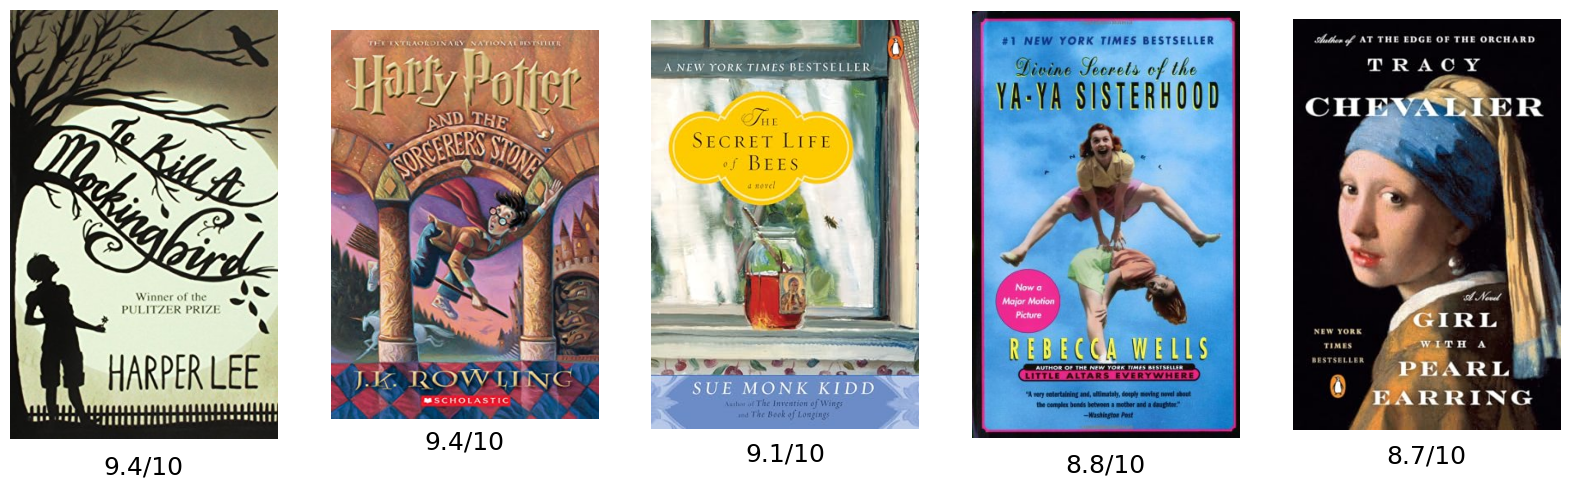

In [76]:
recommend(277427, 5)